In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.executable)

/Users/vidhate/Documents/work/learn-react-agent/.venv/bin/python


In [7]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")


True

### Plan
Follow the guide by Langchain on creating [ReAct agents from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/).  

Steps to build Agent as a langgraph -  
1. Define a State for the Agent - implicit implementation of an `add_messages` [reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#using-messages-in-your-graph)  
2. Define a chat model  
3. Define Tools that the chat model can use  
4. Bind model with tools - implicit implementation of providing a definition of available tools to an LLM with schema    
5. Create Reasoning and Action nodes  
6. Create conditional edge that determines whether to return or to continue ReAct iteration  

### Notes  
1. The "Action" part of the ReAct agent needs a node of its own that can handle executing actions (tool calls) and gathering back the results and making it available back in a reasonable observation form (message history) for the LLM     
2. The list of Actions (or tools) need to be defined globally, and then be made available to the reasoning LLM and the action executor both separately   
3. The conditional logic on when to end vs keep doing ReAct is assumed to be when there are no more tool calls.   


### Customizations  
1. The LLM can have a multi-step reasoning process in the "reason" node - in the most general form it can be a workflow chain of multiple steps like COT followed by debate etc.  
2. Tools can sometimes live in a space where it's not possible to observe the outcome of execution - example display results in a carousel FE component - what is a better way to deal in such situations? - provide back a dummy output to the LLM (success / fail) or update conditional logic of contiue vs END to ignore certain tool calls  
3. Model can be dynamically binded to tools in the reason node allowing tools to be "unlocked" for a model instead of offering them universally - for example when certain tools are behind a paywall  
4. Conditional logic can be much more complex on when to end reasoning instead of it being a simple "END when no tool calls"  
5. Distinct Input and Output states and help format outptus better for Tools + Response type situations  
6. Context Engineering is important across the board - likely a mix of how States are defined and what gets used and how in the reasoning node  

In [21]:
from typing import List
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    character_traits: List[str] = []

In [10]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [13]:
from langchain_core.tools import tool

@tool
def get_weather(location: str) -> str:
    """Get the weather for a specific location."""
    if location in ["New York", "New York City", "NYC"]:
        return "The weather in New York is sunny and 72 degrees Fahrenheit."
    elif location in ["San Francisco", "SF", "Bay Area"]:
        return "The weather in San Francisco is sunny and 60 degrees Fahrenheit."
    else:
        return "Cannot get weather for {location}."

In [14]:
tools = [get_weather]
model = model.bind_tools(tools) # presumes that I want to present all tools to the model always

In [33]:
from langchain_core.messages import ToolMessage, SystemMessage

tool_map = {tool.name: tool for tool in tools}

def execute_action(state: AgentState) -> AgentState:
    """Execute an action and return the result."""

    action_results = []
    for tool_call in state["messages"][-1].tool_calls: # this line assumes that parallel tool calls are supported by the LLM and all tool calls are made in a single message
        tool_name = tool_call["name"]
        tool_input = tool_call["args"]
        tool_result = tool_map[tool_name].invoke(tool_input)
        action_results.append(ToolMessage(content=tool_result, tool_call_id=tool_call["id"], tool_name=tool_name))

    return {"messages": action_results}


def reasoning_node(state: AgentState) -> AgentState:
    """Reasoning node that uses the LLM to reason about how to best help user given their request"""

    system_prompt = SystemMessage(content="You are a helpful AI assistant, please respond to the users query to the best of your ability!")
    response = model.invoke([system_prompt, *state["messages"]])
    return {"messages": [response]}

In [27]:
def should_continue_react(state: AgentState):
    """Logic to determine if the agent should continue reasoning or return the result"""
    if state["messages"][-1].tool_calls:
        return "actions"
    return "respond"

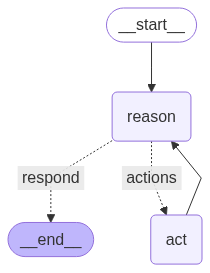

In [34]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

agent_builder = StateGraph(AgentState)
agent_builder.add_node("act", execute_action)
agent_builder.add_node("reason", reasoning_node)
agent_builder.add_edge(START, "reason")
agent_builder.add_conditional_edges("reason", should_continue_react, {"actions": "act", "respond": END})
agent_builder.add_edge("act", "reason")

agent = agent_builder.compile()

from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
agent.invoke({"messages": [HumanMessage(content="What is the weather in Mumbai?")]})

{'messages': [HumanMessage(content='What is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='7058a893-86d1-4b20-81c4-15c51c33cd66'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UHYLfAXhdc8csyOaVx3QqRVt', 'function': {'arguments': '{"location":"Mumbai"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 72, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bm8ab1Lv5YJ7eCR5ZEsgeQbi3pYMz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac60b7d6-01dc-467d-b45e-58995cef18d0-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, '